In [233]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Oct 24

@author: yaning
"""

import HH as HH
import importlib
import numpy as np
import matplotlib.pyplot as plt

importlib.reload(HH)

<module 'HH' from '/home/yaning/Documents/Spiking_NN/HH.py'>

In [234]:
# simulation environment
deltaTms = 0.05
Cm = 1
# other Vm initialisation can lead to random firing
Vm = 1.3458754117369027
# 5000 cycles and every cycle is 0.01ms
# in total 50ms
pointCount = 5000
voltages = np.empty(pointCount)
times = np.arange(pointCount) * deltaTms #record the actual time
stim = np.zeros(pointCount)
# no injection current because the ampa current will be the injection current
stim[1500:4000] = 0  # create a square pulse

# presynapse firing
first_pre_firing = list(range(500, 521)) 
second_pre_firing = list(range(1500, 2000))
tsp_pre = first_pre_firing + second_pre_firing


In [235]:
tsp_pre

[500,
 501,
 502,
 503,
 504,
 505,
 506,
 507,
 508,
 509,
 510,
 511,
 512,
 513,
 514,
 515,
 516,
 517,
 518,
 519,
 520,
 1500,
 1501,
 1502,
 1503,
 1504,
 1505,
 1506,
 1507,
 1508,
 1509,
 1510,
 1511,
 1512,
 1513,
 1514,
 1515,
 1516,
 1517,
 1518,
 1519,
 1520,
 1521,
 1522,
 1523,
 1524,
 1525,
 1526,
 1527,
 1528,
 1529,
 1530,
 1531,
 1532,
 1533,
 1534,
 1535,
 1536,
 1537,
 1538,
 1539,
 1540,
 1541,
 1542,
 1543,
 1544,
 1545,
 1546,
 1547,
 1548,
 1549,
 1550,
 1551,
 1552,
 1553,
 1554,
 1555,
 1556,
 1557,
 1558,
 1559,
 1560,
 1561,
 1562,
 1563,
 1564,
 1565,
 1566,
 1567,
 1568,
 1569,
 1570,
 1571,
 1572,
 1573,
 1574,
 1575,
 1576,
 1577,
 1578,
 1579,
 1580,
 1581,
 1582,
 1583,
 1584,
 1585,
 1586,
 1587,
 1588,
 1589,
 1590,
 1591,
 1592,
 1593,
 1594,
 1595,
 1596,
 1597,
 1598,
 1599,
 1600,
 1601,
 1602,
 1603,
 1604,
 1605,
 1606,
 1607,
 1608,
 1609,
 1610,
 1611,
 1612,
 1613,
 1614,
 1615,
 1616,
 1617,
 1618,
 1619,
 1620,
 1621,
 1622,
 1623,
 1624,

In [236]:
sodium_channel = HH.Voltage_Sodium(Vm)
potassium_channel = HH.Voltage_Potassium(Vm)
leaky_channel = HH.Voltage_Leak(Vm)

# because I am using factory, so the initialised values stay the same
# even the below line runs again
ampa_receptor = HH.LigandGatedChannelFactory.create_AMPA(Vm)

na_currents = []
k_currents = []
leak_currents = []
ampa_currents = []
ampa_gps = []

include_ampa = 1

for i in range(len(times)):

    sodium_channel.update_gP(deltaTms)
    potassium_channel.update_gP(deltaTms)

    if include_ampa:
        ampa_receptor.update_gP(i, deltaTms, tsp_pre)
    ampa_gps.append(ampa_receptor.gP)
    # # get the currents
    # INa = sodium_channel.current()
    # IK = potassium_channel.current()
    # Ileak = leaky_channel.current()

    # if include_ampa:
    #     Iampa = ampa_receptor.current()
    #     ampa_currents.append(Iampa)

    try:
        # get the currents
        INa = sodium_channel.current()
        IK = potassium_channel.current()
        Ileak = leaky_channel.current()

        if include_ampa:
            Iampa = ampa_receptor.current()
            ampa_currents.append(Iampa)
        else:
            Iampa = 1
        

        # check for over or underflow
        if any(current > 1e10 for current in [INa, IK, Ileak, Iampa]):
            raise OverflowError("overflowed")
        
    except OverflowError as m:
        print(f"error: {m}")
        break

    threshold = 1e-10  # Define your underflow threshold

    # Replace underflowing currents with 0
    INa = INa if abs(INa) >= threshold else 0
    IK = IK if abs(IK) >= threshold else 0
    Ileak = Ileak if abs(Ileak) >= threshold else 0
    Iampa = Iampa if abs(Iampa) >= threshold else 0


    na_currents.append(INa)
    k_currents.append(IK)
    leak_currents.append(Ileak)

    
    # print(f"time is {i}")
    # print(f"INa is {INa}")
    # print(f"IK is {IK}")
    # print(f"Ileak is {Ileak}")
    # if include_ampa:
    #     print(f"Iampa is {Iampa}")
    
    # print("\n")

    # sum the currents
    if include_ampa:
        Isum = stim[i] - INa - IK - Ileak -Iampa
    else:
        Isum = stim[i] - INa - IK - Ileak 

    Vm += deltaTms * Isum / Cm

    voltages[i] = Vm

    # update the voltages for each channel
    sodium_channel.Vm = Vm
    potassium_channel.Vm = Vm
    leaky_channel.Vm = Vm

    if include_ampa:
        ampa_receptor.Vm = Vm

        # when post synaptic fires weight updates
        if i >= 2:
            if voltages[i-2] <= voltages[i-1] and voltages[i-1] >= voltages[i]:
                ampa_receptor.update_w(i)
                print(f"this is activated at {i}")




this is activated at 244
this is activated at 567
this is activated at 892
this is activated at 1227
this is activated at 1633
this is activated at 1963
this is activated at 2339
this is activated at 2657
this is activated at 2978
this is activated at 3297
this is activated at 3605


In [237]:
HH.LigandGatedChannelFactory.gMax_AMPA

0.0072

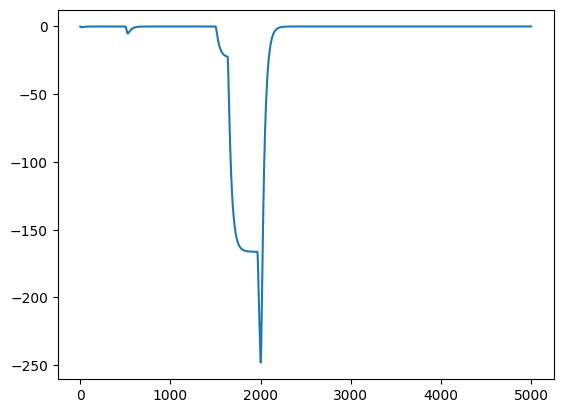

In [238]:
plt.plot(ampa_gps , label="leaky")

In [239]:
# ampa_gps

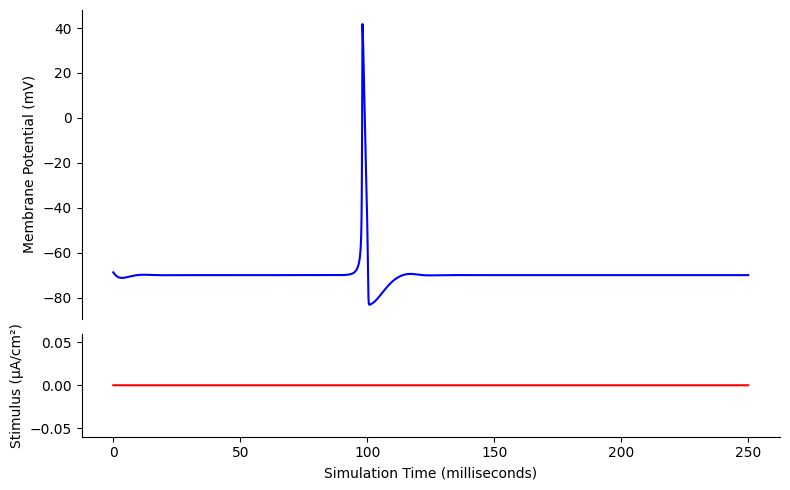

In [240]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 5),
                                gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(times, voltages - 70, 'b')
ax1.set_ylabel("Membrane Potential (mV)")
# ax1.set_title("Hodgkin-Huxley Spiking Neuron Model", fontSize=16)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(bottom=False)

ax2.plot(times, stim, 'r')
ax2.set_ylabel("Stimulus (µA/cm²)")
ax2.set_xlabel("Simulation Time (milliseconds)")
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.margins(0, 0.1)
plt.tight_layout()
# plt.savefig("dev/concept4.png")
plt.show()

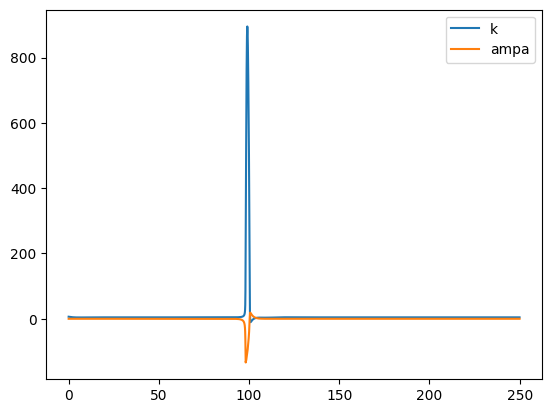

In [241]:
# plt.plot(times, leak_currents, label="leaky")
plt.plot(times, k_currents, label="k")
# plt.plot(times, na_currents, label="na")
plt.plot(times, ampa_currents, label="ampa")
plt.legend()